# Simplicial Complexes and Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from sklearn.metrics import pairwise_distances

Let's start by constructing a toy dataset.

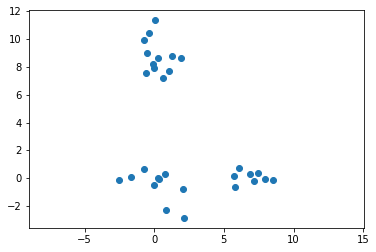

In [2]:
# In the multivariate_normal function, the first vector is the mean values, 
# whereas the second array is the covariance matrix.
X1 = np.random.multivariate_normal([0,0],np.array([[1,0],[0,1]]),size = 10)
X2 = np.random.multivariate_normal([7,0],np.array([[1,0],[0,0.2]]),size = 8)
X3 = np.random.multivariate_normal([0,9],np.array([[.6,0],[0,2]]),size = 12)

X = np.concatenate((X1,X2,X3))

plt.plot(X[:,0],X[:,1],'o')
plt.axis('equal')
plt.show()

## Creating a Growing Simplicial Complex

First we create a distance matrix for $X$.

In [4]:
def create_1_dim_simplicial_complex(D,r):
    """
    Input: distance matrix and nonnegative radius
    Output: networkx graph 
    """
    
    G = nx.Graph()
    G.add_nodes_from(list(range(len(D))))
    edge_list = np.argwhere(D <= r) 
    G.add_edges_from(edge_list)
    
    # Remove self-loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    return G

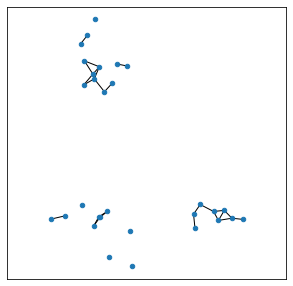

In [6]:
D = pairwise_distances(X)
pos = {n:X[n,:] for n in range(len(X))}
G = create_1_dim_simplicial_complex(D,1)
plt.figure(figsize = (5,5))
nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 20)
plt.axis('equal')
plt.show()

Now let's look at how this evolves over a few radii:

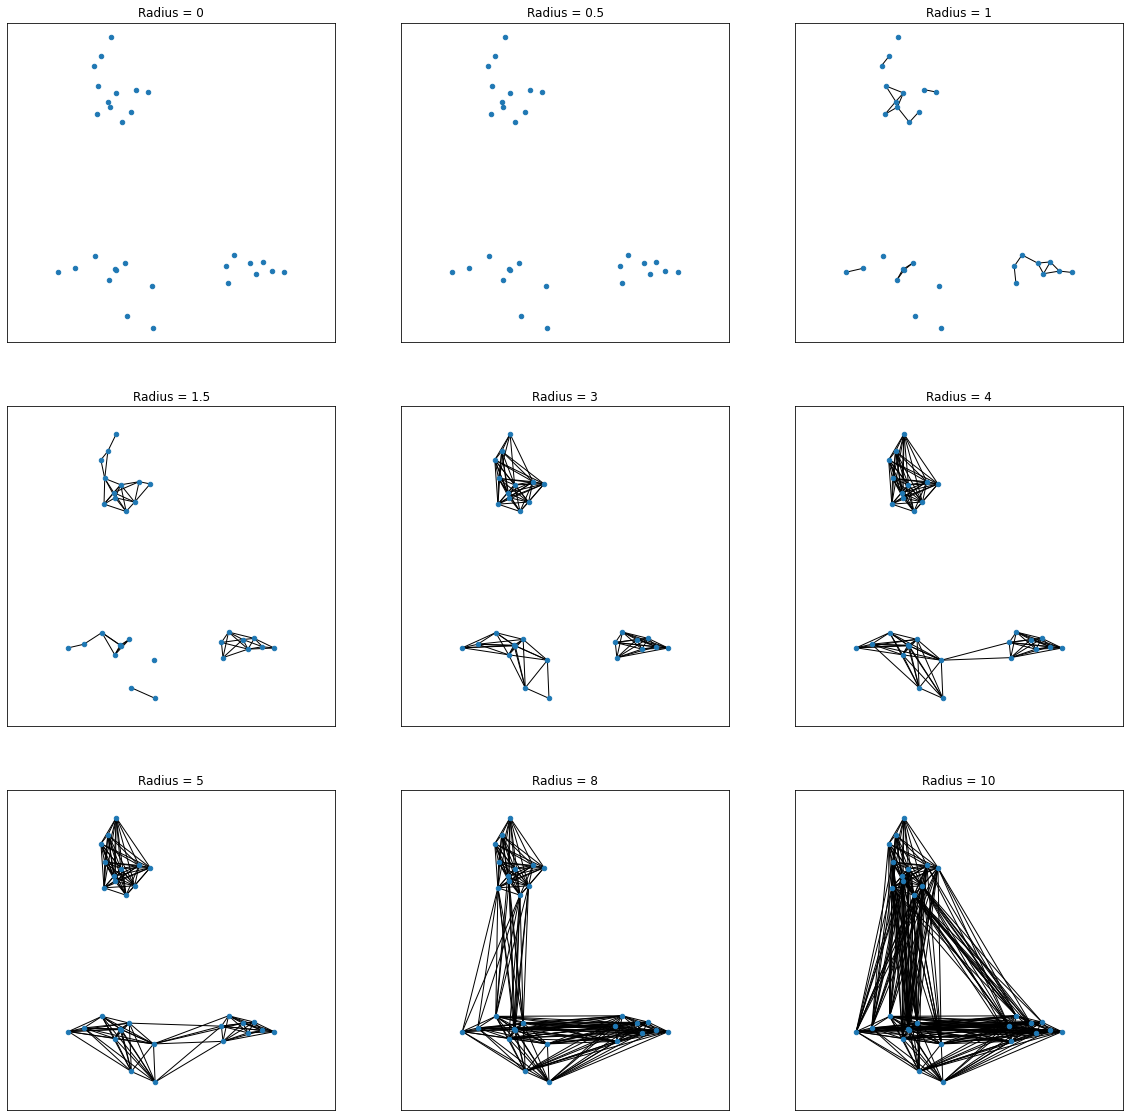

In [7]:
rs = [0,0.5,1,1.5,3,4,5,8,10]

plt.figure(figsize = (20,20))

for (j,r) in enumerate(rs):
    G = create_1_dim_simplicial_complex(D,r)
    plt.subplot(3,3,j+1)
    nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 20)
    plt.axis('equal')
    plt.title('Radius = '+str(r))

plt.show()

## Vietoris-Rips Complexes

The above construction is (almost) an example of the concept of a *Vietoris-Rips complex* that we defined in class. Recall that if $(X,d)$ is a finite metric space and $r \geq 0$, we define the *Vietoris-Rips complex for $X$ at scale $r$* to be the simplicial complex $\mathrm{VR}_r(X) = (V_r,\Sigma_r)$, where $V_r = X$ for all $r$ and 
$$
\Sigma_r = \{(x_{i_0},\ldots,x_{i_k}) \mid d(x_{i_m},x_{i_n}) \leq r \; \forall \; m,n\}.
$$
The graphs we defined above are the $1$-skeleton of the Vietoris-Rips complexes at various scales; that is, they are the result of taking the Vietoris-Rips complex and throwing away any simplices with dimension $\geq 2$. This is sufficient to extract connectivity information about the data, but there is a reason to include higher-dimensional simplices in the construction.

## Higher-Dimensional Homology

To see how higher-dimensional homology would come into play, let's look at one more example.

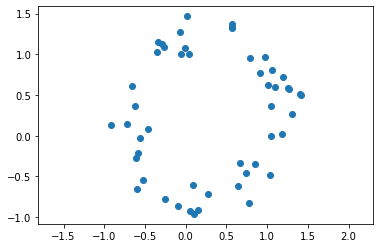

In [8]:
num_points = 50

X = np.random.multivariate_normal([0,0],np.array([[1,0],[0,1]]),size = num_points)
X = X.T/np.linalg.norm(X,axis = 1)
X = X.T + 0.5*np.random.rand(num_points,2)

plt.plot(X[:,0],X[:,1],'o')
plt.axis('equal')
plt.show()

In [9]:
D = pairwise_distances(X)

The $1$-skeleta of the Vietoris-Rips complexes look like this:

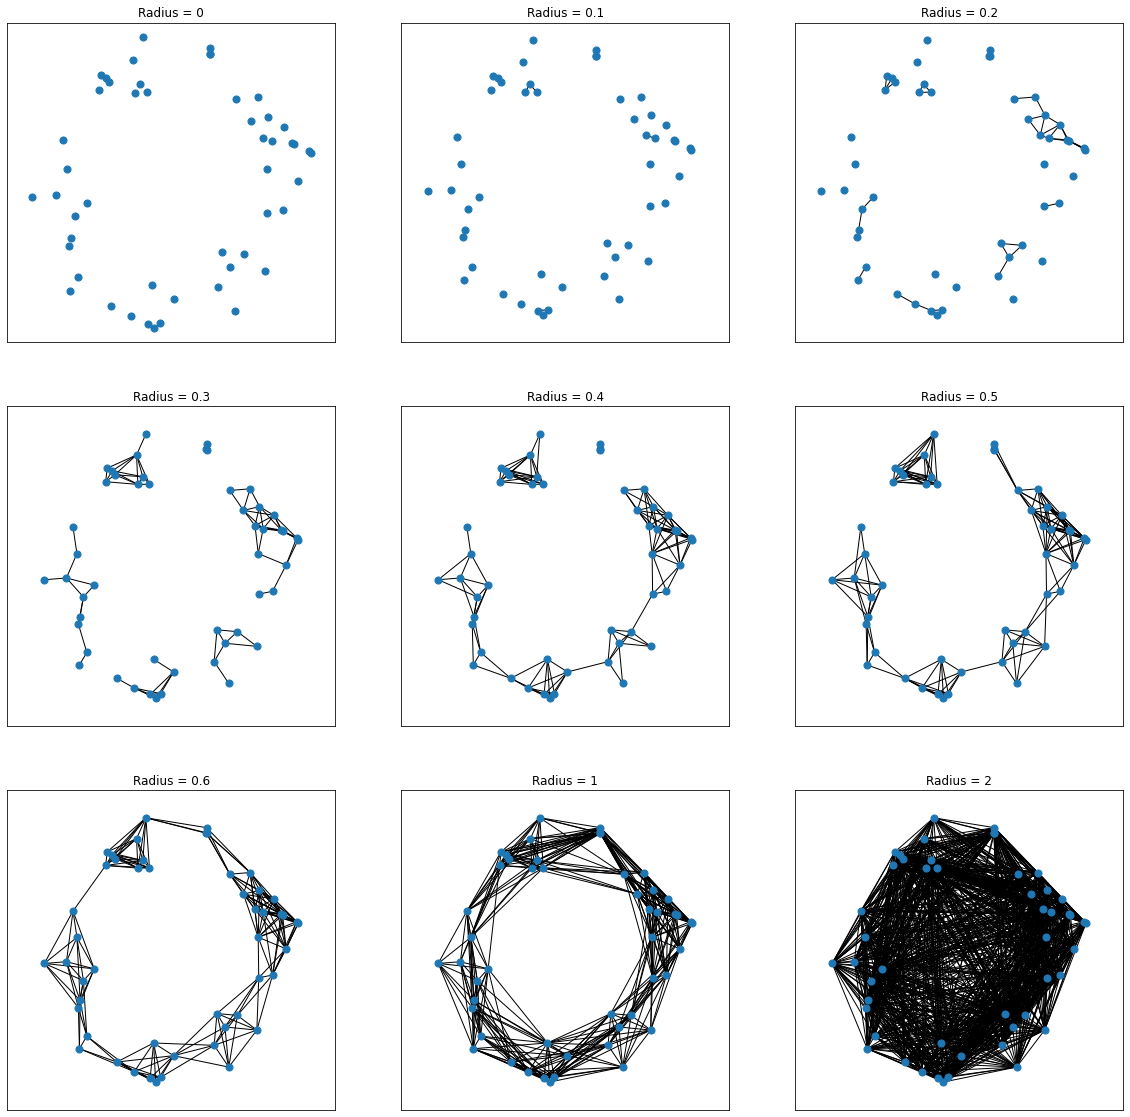

In [10]:
rs = [0,0.1,0.2,0.3,0.4,0.5,0.6,1,2]
pos = {n:X[n,:] for n in range(len(X))}

plt.figure(figsize = (20,20))

for (j,r) in enumerate(rs):
    G = create_1_dim_simplicial_complex(D,r)
    plt.subplot(3,3,j+1)
    nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 50)
    plt.axis('equal')
    plt.title('Radius = '+str(r))

plt.show()

For this dataset, there is a 'loop structure' which may be of interest. To see it computationally, we would want to track $1$-dimensional homology over various scales. As it stands, the 1-dimensional homology would see lots and lots of very small holes, which would not sufficiently accentuate the large apparent loop. We can remedy this by including higher-dimensional simplices.

In what follows, I'll compute the $2$-skeleton of the Vietoris-Rips complexes. Note that if we are interested in degree-$k$ homology of the dataset, it suffices to use the $k+1$-skeleton of the VR complex, since
$$
H_k(\mathrm{VR}_r(X)) = \mathrm{ker}(\partial_k) / \mathrm{im}(\partial_{k+1}).
$$

We need to use some more involved tools to compute and draw $2$-simplices.

Let's work at a fixed resolution to design the plotting tool.

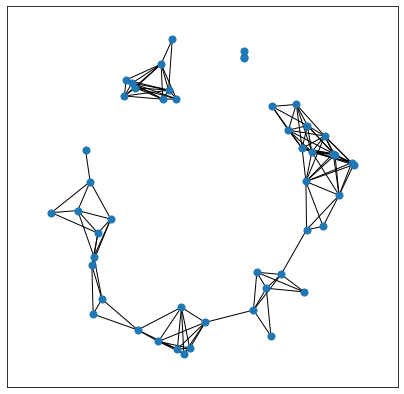

In [11]:
plt.figure(figsize = (7,7))
r = 0.4
G = create_1_dim_simplicial_complex(D,r)
nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 50)
plt.axis('equal')
plt.show()

In [12]:
def create_2_dim_simplicial_complex(D,r):
    
    # Create 1-skeleton
    G = create_1_dim_simplicial_complex(D,r)
    
    # Get a list of 2-simplices
    two_spx_list = []
    
    # Naive search for viable 2-simplices
    for edge in G.edges():
        for vertex in G.nodes():
            if vertex != edge[0] and vertex != edge[1] and D[edge[0],vertex] < r and D[edge[1],vertex] < r:
                two_spx_list.append([edge[0],edge[1],vertex])
                
    return G, two_spx_list

In [13]:
G, two_spx_list = create_2_dim_simplicial_complex(D,r)
two_spx_list

[[0, 11, 24],
 [0, 11, 28],
 [0, 11, 35],
 [0, 11, 49],
 [0, 22, 24],
 [0, 22, 28],
 [0, 22, 35],
 [0, 22, 46],
 [0, 22, 49],
 [0, 24, 11],
 [0, 24, 22],
 [0, 24, 28],
 [0, 24, 35],
 [0, 24, 46],
 [0, 24, 49],
 [0, 28, 11],
 [0, 28, 22],
 [0, 28, 24],
 [0, 28, 35],
 [0, 28, 46],
 [0, 28, 49],
 [0, 32, 49],
 [0, 35, 11],
 [0, 35, 22],
 [0, 35, 24],
 [0, 35, 28],
 [0, 35, 46],
 [0, 35, 49],
 [0, 46, 22],
 [0, 46, 24],
 [0, 46, 28],
 [0, 46, 35],
 [0, 46, 49],
 [0, 49, 11],
 [0, 49, 22],
 [0, 49, 24],
 [0, 49, 28],
 [0, 49, 32],
 [0, 49, 35],
 [0, 49, 46],
 [1, 13, 15],
 [1, 13, 21],
 [1, 13, 27],
 [1, 13, 33],
 [1, 13, 38],
 [1, 15, 13],
 [1, 15, 33],
 [1, 15, 38],
 [1, 21, 13],
 [1, 21, 27],
 [1, 21, 33],
 [1, 21, 38],
 [1, 27, 13],
 [1, 27, 21],
 [1, 27, 33],
 [1, 27, 38],
 [1, 33, 13],
 [1, 33, 15],
 [1, 33, 21],
 [1, 33, 27],
 [1, 33, 38],
 [1, 38, 13],
 [1, 38, 15],
 [1, 38, 21],
 [1, 38, 27],
 [1, 38, 33],
 [2, 3, 6],
 [2, 3, 47],
 [2, 6, 3],
 [2, 6, 47],
 [2, 6, 48],
 [2, 29, 47],

To draw the simplices, we'll use the `Polygon` function imported above. We'll add the triangles one-by-one to a collection, then use plotting tools to display them.

In [14]:
patches = []

for i,spx in enumerate(two_spx_list):
    position_array = np.array([[pos[vert][0],pos[vert][1]] for vert in spx])
    polygon = Polygon(position_array, True)
    patches.append(polygon)

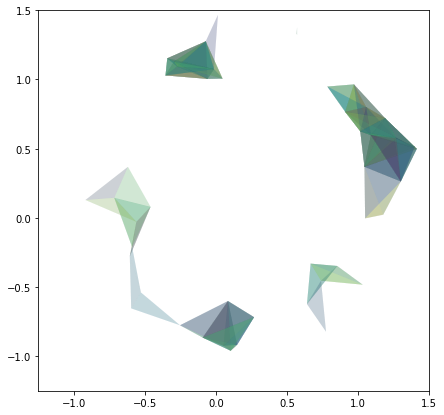

In [15]:
fig, ax = plt.subplots(figsize = (7,7))

colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.1)
p.set_array(np.array(colors))
ax.add_collection(p)

plt.xlim([-1.25, 1.5])
plt.ylim([-1.25, 1.5])
plt.show()

Now we'll plot the 1-skeleton first and overlay the triangles.

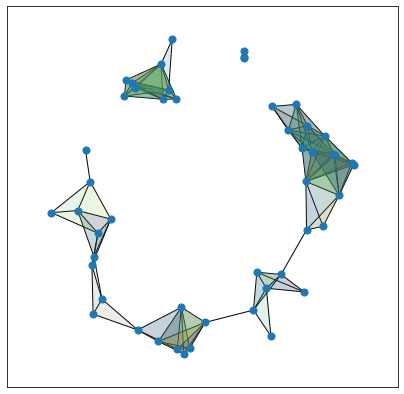

In [16]:
fig, ax = plt.subplots(figsize = (7,7))

nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 50)
colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.05)
p.set_array(np.array(colors))
ax.add_collection(p)

plt.axis('equal')
plt.show()

Looks good! Now let's run it on a range of radii. We'll decrease the max radius in our pictures, since the number of triangles blows up factorially and it eventually takes forever to draw all of them.

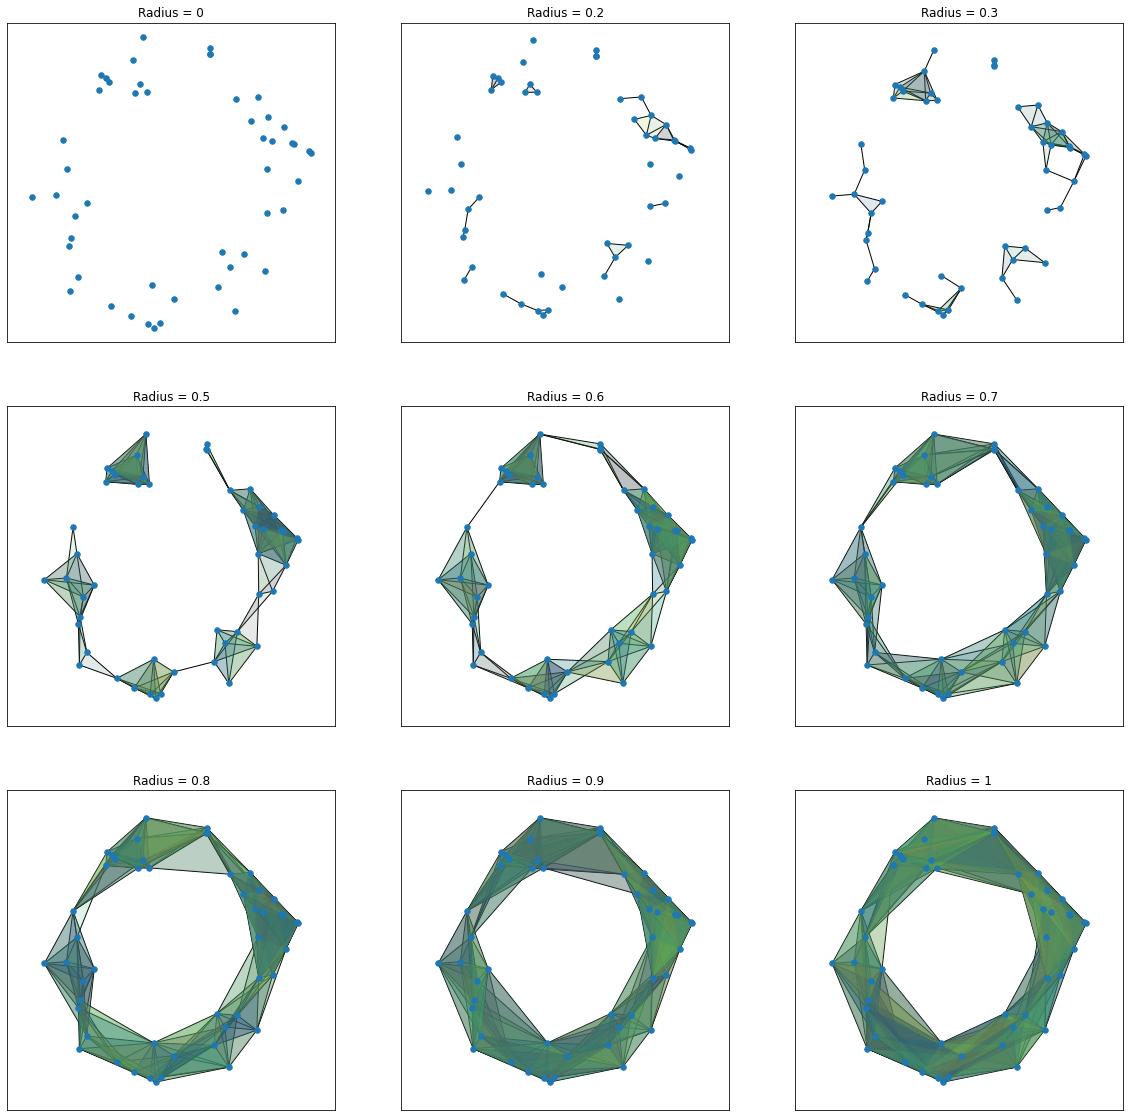

In [17]:
rs = [0,0.2,0.3,0.5,0.6,0.7,0.8,0.9,1]
pos = {n:X[n,:] for n in range(len(X))}

plt.figure(figsize = (20,20))

for (j,r) in enumerate(rs):
    G, two_spx_list = create_2_dim_simplicial_complex(D,r)
    patches = []

    for i,spx in enumerate(two_spx_list):
        position_array = np.array([[pos[vert][0],pos[vert][1]] for vert in spx])
        polygon = Polygon(position_array, True)
        patches.append(polygon)
        
    ax = plt.subplot(3,3,j+1)
    nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 30)
    colors = 100*np.random.rand(len(patches))
    p = PatchCollection(patches, alpha=0.05)
    p.set_array(np.array(colors))
    ax.add_collection(p)
    
    plt.axis('equal')
    plt.title('Radius = '+str(r))

plt.show()

We see that loops appear in the data:
- small loops appear earlier in the process but are quickly filled in
- a much stronger loop appears a bit later but persists for a long time
- the large loop will also eventually be filled in, but the idea is that keep track of how features change over 'filtration values' (values of $r$).